In [11]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse

In [12]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_rmse, label='Train RMSE')
    plt.plot(val_rmse, label='Val RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()

    plt.show()


In [13]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})
    
    plt.figure(figsize=(10, 6))
    plt.plot(df.index[start:end], df['Predictions'][start:end], label='Predictions')
    plt.plot(df.index[start:end], df['Actuals'][start:end], label='Actuals')
    plt.xlabel('Time')
    plt.ylabel('Temperature (degC)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [14]:
def plot_predictions(model, X, y, index, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions[start:end], 'Actuals': y[start:end]})
    df['Date'] = index[start:end]

    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['Predictions'], label='Predictions')
    plt.plot(df['Date'], df['Actuals'], label='Actuals')
    plt.xlabel('Time')
    plt.ylabel('Temperature (degC)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()



In [15]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df = df[5::6]
df


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


<Axes: xlabel='Date Time'>

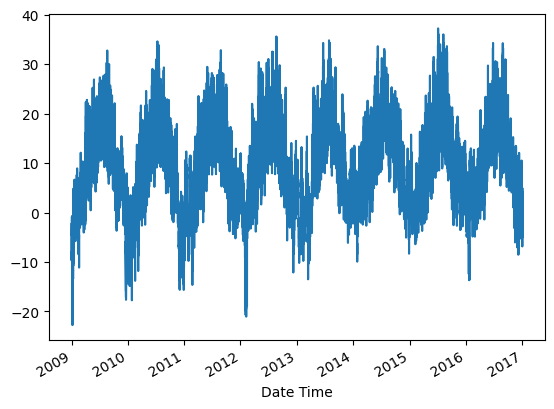

In [16]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
temp = df['T (degC)']
temp.plot()

<Axes: xlabel='Date Time'>

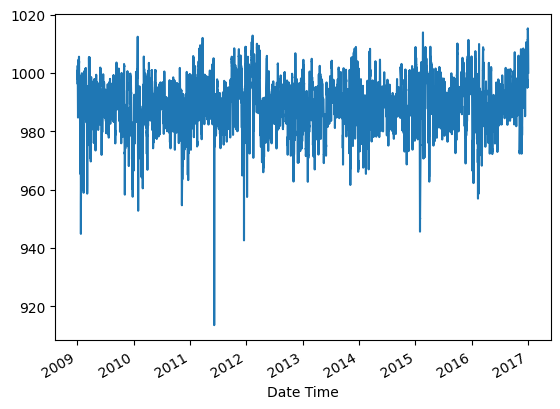

In [17]:
atmospheric_pressure = df['p (mbar)']
atmospheric_pressure.plot()

<Axes: xlabel='Date Time'>

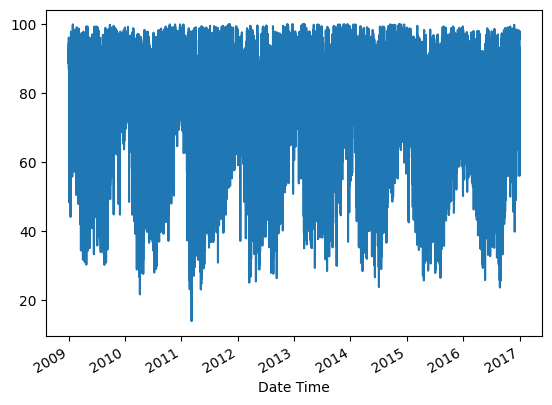

In [18]:
humidity = df['rh (%)']
humidity.plot()

In [19]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [20]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]

In [21]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [22]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
history1 = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
1874/1875 [============================>.] - ETA: 0s - loss: 37.1890 - root_mean_squared_error: 6.0983

1875/1875 [==============================] - 23s 7ms/step - loss: 37.1708 - root_mean_squared_error: 6.0968 - val_loss: 1.7559 - val_root_mean_squared_error: 1.3251
Epoch 2/50
1867/1875 [============================>.] - ETA: 0s - loss: 2.8816 - root_mean_squared_error: 1.6975

1875/1875 [==============================] - 14s 8ms/step - loss: 2.8758 - root_mean_squared_error: 1.6958 - val_loss: 0.7145 - val_root_mean_squared_error: 0.8453
Epoch 3/50
1871/1875 [============================>.] - ETA: 0s - loss: 1.0241 - root_mean_squared_error: 1.0120

1875/1875 [==============================] - 16s 9ms/step - loss: 1.0235 - root_mean_squared_error: 1.0117 - val_loss: 0.5523 - val_root_mean_squared_error: 0.7432
Epoch 4/50
1869/1875 [============================>.] - ETA: 0s - loss: 0.7419 - root_mean_squared_error: 0.8613

1875/1875 [==============================] - 12s 6ms/step - loss: 0.7412 - root_mean_squared_error: 0.8610 - val_loss: 0.5090 - val_root_mean_squared_error: 0.7135
Epoch 5/50
1866/1875 [============================>.] - ETA: 0s - loss: 0.6816 - root_mean_squared_error: 0.8256

1875/1875 [==============================] - 12s 6ms/step - loss: 0.6818 - root_mean_squared_error: 0.8257 - val_loss: 0.5003 - val_root_mean_squared_error: 0.7073
Epoch 6/50
1869/1875 [============================>.] - ETA: 0s - loss: 0.6635 - root_mean_squared_error: 0.8145

1875/1875 [==============================] - 12s 6ms/step - loss: 0.6640 - root_mean_squared_error: 0.8149 - val_loss: 0.4957 - val_root_mean_squared_error: 0.7041
Epoch 7/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6574 - root_mean_squared_error: 0.8108 - val_loss: 0.5060 - val_root_mean_squared_error: 0.7113
Epoch 8/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6517 - root_mean_squared_error: 0.8073 - val_loss: 0.5160 - val_root_mean_squared_error: 0.7183
Epoch 9/50
1871/1875 [============================>.] - ETA: 0s - loss: 0.6490 - root_mean_squared_error: 0.8056

1875/1875 [==============================] - 14s 7ms/step - loss: 0.6491 - root_mean_squared_error: 0.8057 - val_loss: 0.4944 - val_root_mean_squared_error: 0.7032
Epoch 10/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6460 - root_mean_squared_error: 0.8037 - val_loss: 0.4995 - val_root_mean_squared_error: 0.7068
Epoch 11/50
1871/1875 [============================>.] - ETA: 0s - loss: 0.6445 - root_mean_squared_error: 0.8028

1875/1875 [==============================] - 12s 6ms/step - loss: 0.6444 - root_mean_squared_error: 0.8028 - val_loss: 0.4881 - val_root_mean_squared_error: 0.6986
Epoch 12/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6438 - root_mean_squared_error: 0.8024 - val_loss: 0.5037 - val_root_mean_squared_error: 0.7097
Epoch 13/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6405 - root_mean_squared_error: 0.8003 - val_loss: 0.4983 - val_root_mean_squared_error: 0.7059
Epoch 14/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6398 - root_mean_squared_error: 0.7999 - val_loss: 0.4907 - val_root_mean_squared_error: 0.7005
Epoch 15/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6393 - root_mean_squared_error: 0.7996 - val_loss: 0.4904 - val_root_mean_squared_error: 0.7003
Epoch 16/50
1870/1875 [============================>.] - ETA: 0s - loss: 0.6382 - root_mean_squared_error: 0.7989

1875/1875 [==============================] - 12s 6ms/step - loss: 0.6386 - root_mean_squared_error: 0.7991 - val_loss: 0.4847 - val_root_mean_squared_error: 0.6962
Epoch 17/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6376 - root_mean_squared_error: 0.7985 - val_loss: 0.4972 - val_root_mean_squared_error: 0.7051
Epoch 18/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6363 - root_mean_squared_error: 0.7977 - val_loss: 0.4856 - val_root_mean_squared_error: 0.6969
Epoch 19/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6366 - root_mean_squared_error: 0.7979 - val_loss: 0.4927 - val_root_mean_squared_error: 0.7019
Epoch 20/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6347 - root_mean_squared_error: 0.7967 - val_loss: 0.4893 - val_root_mean_squared_error: 0.6995
Epoch 21/50
1875/1875 [==============================] - 8s 5ms/step - loss: 0.6350 - root_mean_squared_error: 0.7968 - val_loss: 0.5114

1875/1875 [==============================] - 12s 6ms/step - loss: 0.6337 - root_mean_squared_error: 0.7960 - val_loss: 0.4836 - val_root_mean_squared_error: 0.6954
Epoch 25/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6329 - root_mean_squared_error: 0.7955 - val_loss: 0.4966 - val_root_mean_squared_error: 0.7047
Epoch 26/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6328 - root_mean_squared_error: 0.7955 - val_loss: 0.4896 - val_root_mean_squared_error: 0.6997
Epoch 27/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6321 - root_mean_squared_error: 0.7950 - val_loss: 0.4976 - val_root_mean_squared_error: 0.7054
Epoch 28/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6318 - root_mean_squared_error: 0.7948 - val_loss: 0.5030 - val_root_mean_squared_error: 0.7092
Epoch 29/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6320 - root_mean_squared_error: 0.7950 - val_loss: 0.4969

1875/1875 [==============================] - 13s 7ms/step - loss: 0.6301 - root_mean_squared_error: 0.7938 - val_loss: 0.4831 - val_root_mean_squared_error: 0.6951
Epoch 35/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6305 - root_mean_squared_error: 0.7940 - val_loss: 0.4923 - val_root_mean_squared_error: 0.7016
Epoch 36/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6298 - root_mean_squared_error: 0.7936 - val_loss: 0.4918 - val_root_mean_squared_error: 0.7013
Epoch 37/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933 - val_loss: 0.4908 - val_root_mean_squared_error: 0.7006
Epoch 38/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6291 - root_mean_squared_error: 0.7931 - val_loss: 0.4831 - val_root_mean_squared_error: 0.6951
Epoch 39/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6288 - root_mean_squared_error: 0.7930 - val_loss: 0.4870

1875/1875 [==============================] - 11s 6ms/step - loss: 0.6276 - root_mean_squared_error: 0.7922 - val_loss: 0.4830 - val_root_mean_squared_error: 0.6950
Epoch 48/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6269 - root_mean_squared_error: 0.7917 - val_loss: 0.4907 - val_root_mean_squared_error: 0.7005
Epoch 49/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6275 - root_mean_squared_error: 0.7922 - val_loss: 0.4985 - val_root_mean_squared_error: 0.7061
Epoch 50/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6273 - root_mean_squared_error: 0.7920 - val_loss: 0.4841 - val_root_mean_squared_error: 0.6957


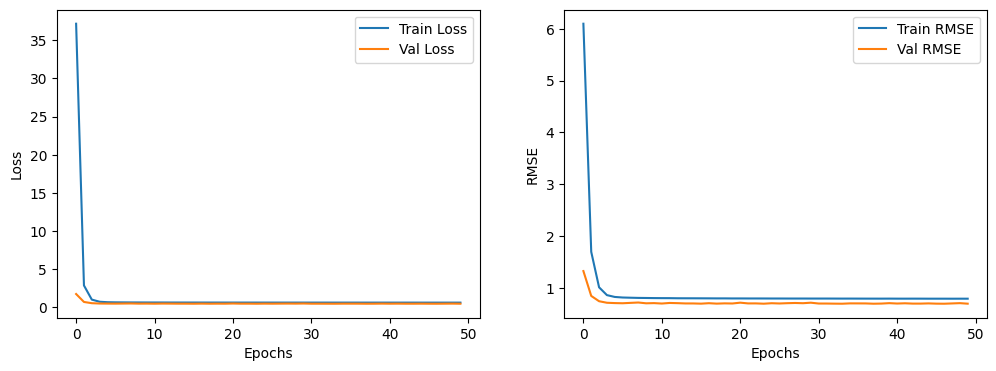

In [23]:
plot_learning_curves(history1)

159/159 [==============================] - 1s 4ms/step


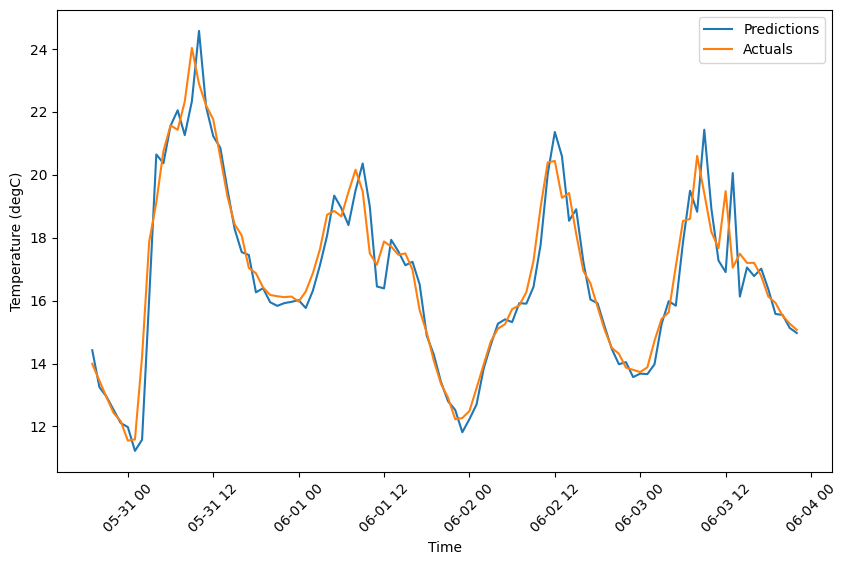

In [25]:
plot_predictions(model1, X_test1, y_test1, df.index[65000:], start=0, end=100)


In [26]:
def evaluate_model(model, X, y):
    predictions = model.predict(X).flatten()
    mse_value = mse(y, predictions)
    rmse_value = np.sqrt(mse_value)
    return mse_value, rmse_value

In [27]:
train_mse, train_rmse = evaluate_model(model1, X_train1, y_train1)
val_mse, val_rmse = evaluate_model(model1, X_val1, y_val1)
test_mse, test_rmse = evaluate_model(model1, X_test1, y_test1)

print(f"Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}")

159/159 [==============================] - 0s 2ms/step
Train MSE: 0.6221, Train RMSE: 0.7887
Val MSE: 0.4841, Val RMSE: 0.6957
Test MSE: 0.5955, Test RMSE: 0.7717


In [28]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 50,449
Trainable params: 50,449
Non-trainable params: 0
_________________________________________________________________


In [29]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
history2 = model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
1867/1875 [============================>.] - ETA: 0s - loss: 26.0521 - root_mean_squared_error: 5.1041

1875/1875 [==============================] - 25s 10ms/step - loss: 25.9540 - root_mean_squared_error: 5.0945 - val_loss: 1.5043 - val_root_mean_squared_error: 1.2265
Epoch 2/50
1868/1875 [============================>.] - ETA: 0s - loss: 2.2129 - root_mean_squared_error: 1.4876

1875/1875 [==============================] - 18s 10ms/step - loss: 2.2086 - root_mean_squared_error: 1.4861 - val_loss: 0.7661 - val_root_mean_squared_error: 0.8753
Epoch 3/50
1865/1875 [============================>.] - ETA: 0s - loss: 1.1431 - root_mean_squared_error: 1.0691

1875/1875 [==============================] - 18s 10ms/step - loss: 1.1430 - root_mean_squared_error: 1.0691 - val_loss: 0.6448 - val_root_mean_squared_error: 0.8030
Epoch 4/50
1871/1875 [============================>.] - ETA: 0s - loss: 0.9213 - root_mean_squared_error: 0.9598

1875/1875 [==============================] - 18s 10ms/step - loss: 0.9212 - root_mean_squared_error: 0.9598 - val_loss: 0.5912 - val_root_mean_squared_error: 0.7689
Epoch 5/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.8475 - root_mean_squared_error: 0.9206 - val_loss: 0.5940 - val_root_mean_squared_error: 0.7707
Epoch 6/50
1870/1875 [============================>.] - ETA: 0s - loss: 0.8012 - root_mean_squared_error: 0.8951

1875/1875 [==============================] - 18s 10ms/step - loss: 0.8015 - root_mean_squared_error: 0.8953 - val_loss: 0.5387 - val_root_mean_squared_error: 0.7340
Epoch 7/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7789 - root_mean_squared_error: 0.8825 - val_loss: 0.5488 - val_root_mean_squared_error: 0.7408
Epoch 8/50
1872/1875 [============================>.] - ETA: 0s - loss: 0.7576 - root_mean_squared_error: 0.8704

1875/1875 [==============================] - 17s 9ms/step - loss: 0.7573 - root_mean_squared_error: 0.8702 - val_loss: 0.5068 - val_root_mean_squared_error: 0.7119
Epoch 9/50
1875/1875 [==============================] - 10s 6ms/step - loss: 0.7515 - root_mean_squared_error: 0.8669 - val_loss: 0.5141 - val_root_mean_squared_error: 0.7170
Epoch 10/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7508 - root_mean_squared_error: 0.8665 - val_loss: 0.5367 - val_root_mean_squared_error: 0.7326
Epoch 11/50
1868/1875 [============================>.] - ETA: 0s - loss: 0.7364 - root_mean_squared_error: 0.8582

1875/1875 [==============================] - 18s 10ms/step - loss: 0.7368 - root_mean_squared_error: 0.8584 - val_loss: 0.4887 - val_root_mean_squared_error: 0.6991
Epoch 12/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.7355 - root_mean_squared_error: 0.8576 - val_loss: 0.5044 - val_root_mean_squared_error: 0.7102
Epoch 13/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7293 - root_mean_squared_error: 0.8540 - val_loss: 0.5212 - val_root_mean_squared_error: 0.7219
Epoch 14/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7261 - root_mean_squared_error: 0.8521 - val_loss: 0.5033 - val_root_mean_squared_error: 0.7094
Epoch 15/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7196 - root_mean_squared_error: 0.8483 - val_loss: 0.4955 - val_root_mean_squared_error: 0.7039
Epoch 16/50
1875/1875 [==============================] - 12s 7ms/step - loss: 0.7202 - root_mean_squared_error: 0.8486 - val_loss: 

1875/1875 [==============================] - 19s 10ms/step - loss: 0.7172 - root_mean_squared_error: 0.8469 - val_loss: 0.4856 - val_root_mean_squared_error: 0.6968
Epoch 19/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7112 - root_mean_squared_error: 0.8433 - val_loss: 0.5025 - val_root_mean_squared_error: 0.7089
Epoch 20/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7122 - root_mean_squared_error: 0.8439 - val_loss: 0.4896 - val_root_mean_squared_error: 0.6997
Epoch 21/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7088 - root_mean_squared_error: 0.8419 - val_loss: 0.4870 - val_root_mean_squared_error: 0.6978
Epoch 22/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.7082 - root_mean_squared_error: 0.8415 - val_loss: 0.5088 - val_root_mean_squared_error: 0.7133
Epoch 23/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7048 - root_mean_squared_error: 0.8395 - val_loss: 

1875/1875 [==============================] - 18s 9ms/step - loss: 0.7081 - root_mean_squared_error: 0.8415 - val_loss: 0.4855 - val_root_mean_squared_error: 0.6968
Epoch 25/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7019 - root_mean_squared_error: 0.8378 - val_loss: 0.5168 - val_root_mean_squared_error: 0.7189
Epoch 26/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7045 - root_mean_squared_error: 0.8393 - val_loss: 0.4994 - val_root_mean_squared_error: 0.7066
Epoch 27/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7004 - root_mean_squared_error: 0.8369 - val_loss: 0.4917 - val_root_mean_squared_error: 0.7012
Epoch 28/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6992 - root_mean_squared_error: 0.8362 - val_loss: 0.5065 - val_root_mean_squared_error: 0.7117
Epoch 29/50
1872/1875 [============================>.] - ETA: 0s - loss: 0.7007 - root_mean_squared_error: 0.8371

1875/1875 [==============================] - 18s 10ms/step - loss: 0.7003 - root_mean_squared_error: 0.8368 - val_loss: 0.4800 - val_root_mean_squared_error: 0.6928
Epoch 30/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6980 - root_mean_squared_error: 0.8355 - val_loss: 0.4930 - val_root_mean_squared_error: 0.7022
Epoch 31/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6947 - root_mean_squared_error: 0.8335 - val_loss: 0.4904 - val_root_mean_squared_error: 0.7003
Epoch 32/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6952 - root_mean_squared_error: 0.8338 - val_loss: 0.4853 - val_root_mean_squared_error: 0.6966
Epoch 33/50
1875/1875 [==============================] - 10s 6ms/step - loss: 0.6966 - root_mean_squared_error: 0.8346 - val_loss: 0.4849 - val_root_mean_squared_error: 0.6964
Epoch 34/50
1875/1875 [==============================] - 10s 6ms/step - loss: 0.6928 - root_mean_squared_error: 0.8323 - val_loss: 

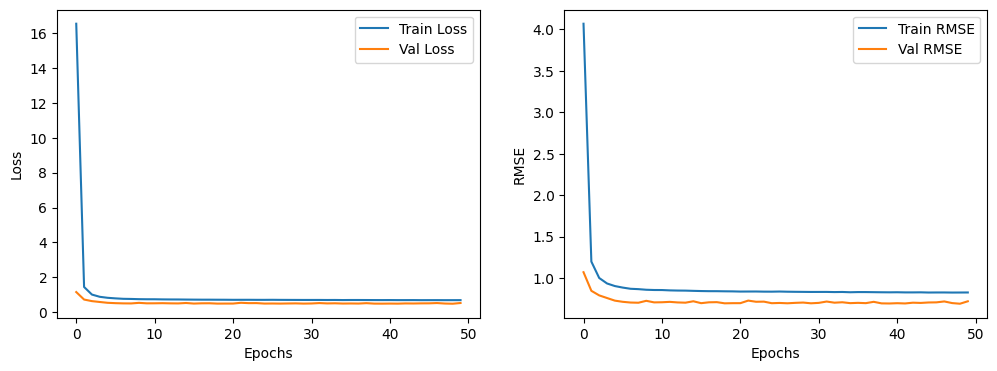

In [ ]:
plot_learning_curves(history2)

159/159 [==============================] - 0s 2ms/step


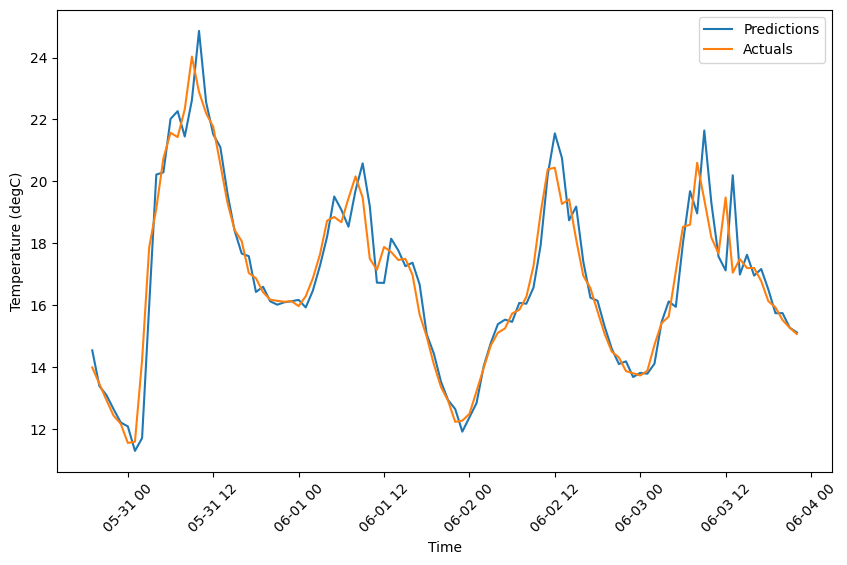

In [31]:
plot_predictions(model2, X_test1, y_test1, df.index[65000:], 0, 100)

In [ ]:
train_mse, train_rmse = evaluate_model(model2, X_train1, y_train1)
val_mse, val_rmse = evaluate_model(model2, X_val1, y_val1)
test_mse, test_rmse = evaluate_model(model2, X_test1, y_test1)

print(f"Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}")

159/159 [==============================] - 0s 2ms/step
Train MSE: 0.6620, Train RMSE: 0.8136
Val MSE: 0.5193, Val RMSE: 0.7206
Test MSE: 0.6155, Test RMSE: 0.7846
